## Module

In [ ]:
import os, sys, urllib, warnings, errno, logging, time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

import torch.nn as nn

In [ ]:
sys.path.append('/content/drive/MyDrive/Research2021/IAF')

In [ ]:
from two_barycenter import *
from util import create_deep_tree_cd
from metrics import *

from ddl.base import (CompositeDestructor, DestructorMixin, create_inverse_transformer, 
                      BoundaryWarning, DataConversionWarning, IdentityDestructor)
from ddl.independent import IndependentDensity, IndependentDestructor, IndependentInverseCdf
from ddl.linear import LinearProjector
from ddl.univariate import HistogramUnivariateDensity, ScipyUnivariateDensity
from ddl.deep import DeepDestructor
from ddl.linear import LinearProjector, RandomOrthogonalEstimator, BestLinearReconstructionDestructor
from weakflow import *

warnings.simplefilter('ignore', BoundaryWarning) # Ignore boundary warnings from ddl
warnings.simplefilter('ignore', DataConversionWarning) # Ignore data conversion warnings from ddl

## SIG

In [ ]:
sys.path.append('/content/drive/MyDrive/Research2021/IAF/SINF')
from SIG import add_one_layer_inverse, SINF

In [ ]:
class SIG(nn.Module):

    # modified from https://github.com/biweidai/SINF

    def __init__(self, ndim, y):
        
        super().__init__()

        classes = unique_labels(y)
        SIT_dict = dict()
        for yy in classes:
            SIT_dict[yy] = SINF(ndim=ndim).requires_grad_(False).cuda() #SIT_dict[0] means generating 0 (1->0)
        self.SIT = SIT_dict
        self.classes = classes
        self.ndim = ndim

    def forward(self,X,y):
        Z = torch.zeros(X.shape)
        for yy in self.classes:
            X_temp = X[np.nonzero(y == yy)[0]]
            SIT_temp = self.SIT[int(1-yy)].cpu()
            zz,_ = SIT_temp(X_temp)
            Z[np.nonzero(y == yy)[0]] = zz
        return Z

    def inverse(self,X,y):
        Z = torch.zeros(X.shape)
        for yy in self.classes:
            X_temp = X[np.nonzero(y == yy)[0]]
            SIT_temp = self.SIT[int(1-yy)].cpu()
            zz,_ = SIT_temp.inverse(X_temp)
            Z[np.nonzero(y == yy)[0]] = zz
        return Z


    def add_newlayer(self,X, y, z_dict,k, nsample_A, nsample_spline, layer_type='regular', batchsize=None, sample_test= None, put_data_on_disk=False):
        # X: the real data that keeps unchanged
        # Z: the data that is moved to X
        for yy in self.classes:
            X_temp = X[np.nonzero(y == yy)[0]] # find the real samples of class yy
            z_temp  = z_dict[int(1-yy)] # find the samples from class 1-yy
            self.SIT[yy], z, z_test = add_one_layer_inverse(self.SIT[yy], X_temp, z_temp,K, nsample_A, nsample_spline, layer_type='regular', 
                                                               batchsize=batchsize, sample_test=sample_test, put_data_on_disk = put_data_on_disk)
            z_dict[int(1-yy)] = z
        return z_dict


## Moon

Train (2000, 2), Test: (1000, 2))


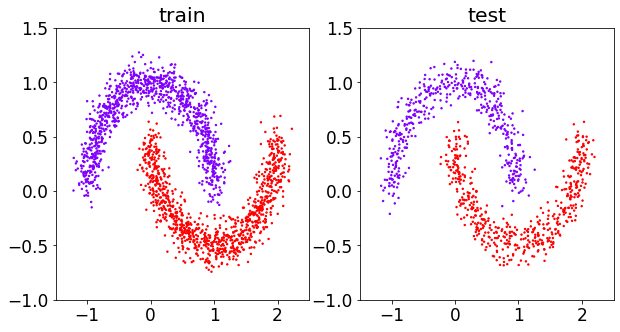

In [ ]:
# Make data
rng = np.random.RandomState(0)
X, y = make_moons(n_samples=3000, noise=0.1, random_state=rng)
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2000, random_state=rng)
# torch.save(X_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_train.pt')
# torch.save(y_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_train.pt')
# torch.save(X_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_test.pt')
# torch.save(y_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_test.pt')

# Load data
X_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_train.pt')
y_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_train.pt')
X_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_test.pt')
y_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_test.pt')

print(f'Train {X_train.shape}, Test: {X_test.shape})')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*X_train.T, c=y_train, s=2, cmap='rainbow')
ax1.set_title('train')
ax2.scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
ax2.set_title('test')
ax1.set_xlim(-1.5,2.5)
ax1.set_ylim(-1,1.5)
ax2.set_xlim(-1.5,2.5)
ax2.set_ylim(-1,1.5)
plt.show()

In [ ]:
def allplot(wd_train,wd_test,tc_train,tc_test,label,first_wd_train,first_wd_test):

    temp_dict = dict()

    wd_mean_train = np.mean(wd_train,axis=0)
    wd_mean_train = np.insert(wd_mean_train,0,first_wd_train)
    wd_std_train =  np.std(wd_train,axis=0)
    wd_std_train = np.insert(wd_std_train,0,0)

    wd_mean_test = np.mean(wd_test,axis=0)
    wd_mean_test = np.insert(wd_mean_test,0,first_wd_test)
    wd_std_test =  np.std(wd_test,axis=0)
    wd_std_test = np.insert(wd_std_test,0,0)

    temp_dict['wd_mean_train'] = wd_mean_train
    temp_dict['wd_std_train'] = wd_std_train
    temp_dict['wd_mean_test'] = wd_mean_test
    temp_dict['wd_std_test'] = wd_std_test


    idx = list(range(0,n_layers+1))


    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,5))
    ax1.plot(idx,wd_mean_train)
    ax1.fill_between(idx,wd_mean_train - wd_std_train , wd_mean_train + wd_std_train , alpha=0.2)
    ax1.set_xlabel('Layers')
    ax1.set_ylabel('Wasserstein Distance')
    ax1.set_title('Train:'+label)

    ax2.plot(idx,wd_mean_test)
    ax2.fill_between(idx,wd_mean_test - wd_std_test , wd_mean_test + wd_std_test , alpha=0.2)
    ax2.set_xlabel('Layers')
    ax2.set_ylabel('Wasserstein Distance')
    ax2.set_title('Test:'+label)
    plt.show()

    # TC
    tc_mean_train = np.mean(tc_train,axis=0)
    tc_std_train =  np.std(tc_train,axis=0)

    tc_mean_test = np.mean(tc_test,axis=0)
    tc_std_test =  np.std(tc_test,axis=0)

    temp_dict['tc_mean_train'] = tc_mean_train
    temp_dict['tc_std_train'] = tc_std_train
    temp_dict['tc_mean_test'] = tc_mean_test
    temp_dict['tc_std_test'] = tc_std_test

    idx = list(range(1,n_layers+1))

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,5))
    ax1.plot(idx,tc_mean_train)
    ax1.fill_between(idx,tc_mean_train - tc_std_train , tc_mean_train + tc_std_train , alpha=0.2)
    ax1.set_xlabel('Layers')
    ax1.set_ylabel('Transportation Cost')
    ax1.set_title('Train:'+label)

    ax2.plot(idx,tc_mean_test)
    ax2.fill_between(idx,tc_mean_test - tc_std_test , tc_mean_test + tc_std_test , alpha=0.2)
    ax2.set_xlabel('Layers')
    ax2.set_ylabel('Transportation Cost')
    ax2.set_title('Test:'+label)
    plt.show()

    return temp_dict    



In [ ]:
# compute WD of Layer 0

sinkhorn = SinkhornDistance(eps=1e-4, max_iter=100)

class_list = [0,1]
n_samples_list = [len(np.nonzero(y_train==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)

X0 = X_train[y_train==0,:]
X0 = X_train[np.nonzero(y_train==0)[0]]
X0 = X0[:n_samples]
y0 = y_train[np.nonzero(y_train==0)[0]]
y0 = y0[:n_samples]
X1 = X_train[np.nonzero(y_train==1)[0]]
X1 = X1[:n_samples]
y1 = y_train[np.nonzero(y_train==1)[0]]
y1 = y1[:n_samples]
original_wd_train = sinkhorn(X0,X1).detach().numpy().item()

n_samples_list = [len(np.nonzero(y_test==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)

X0 = X_test[np.nonzero(y_test==0)[0]]
X0 = X0[:n_samples]
y0 = y_test[np.nonzero(y_test==0)[0]]
y0 = y0[:n_samples]
X1 = X_test[np.nonzero(y_test==1)[0]]
X1 = X1[:n_samples]
y1 = y_test[np.nonzero(y_test==1)[0]]
y1 = y1[:n_samples]
original_wd_test = sinkhorn(X0,X1).detach().numpy().item()


In [ ]:
n_rep = 20
n_layers = 30

In [ ]:
eval_dict = dict()

### sig(01)

In [ ]:
sig_real_train= np.zeros((n_rep,n_layers))
sig_real_test= np.zeros((n_rep,n_layers))

sig_tc_train= np.zeros((n_rep,n_layers))
sig_tc_test= np.zeros((n_rep,n_layers))

device = torch.device('cuda')
# training 

# rearrange the data
class_list = [0,1]
n_samples_list = [len(np.nonzero(y_train==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)

X0 = X_train[y_train==0,:]
X0 = X_train[np.nonzero(y_train==0)[0]]
X0 = X0[:n_samples]
y0 = y_train[np.nonzero(y_train==0)[0]]
y0 = y0[:n_samples]
X1 = X_train[np.nonzero(y_train==1)[0]]
X1 = X1[:n_samples]
y1 = y_train[np.nonzero(y_train==1)[0]]
y1 = y1[:n_samples]

X = np.concatenate((X0,X1))
y = np.concatenate((y0,y1))


# Evaluation
# rearrange the data
n_samples_list_test = [len(np.nonzero(y_test==l)[0]) for l in class_list]
n_samples_test = np.min(n_samples_list_test)
X0 = X_test[np.nonzero(y_test==0)[0]]
X0 = X0[:n_samples_test]
y0 = y_test[np.nonzero(y_test==0)[0]]
y0 = y0[:n_samples_test]
X1 = X_test[np.nonzero(y_test==1)[0]]
X1 = X1[:n_samples_test]
y1 = y_test[np.nonzero(y_test==1)[0]]
y1 = y1[:n_samples_test]

X_test = np.concatenate((X0,X1))
y_test = np.concatenate((y0,y1))

In [ ]:

for t in range(n_rep):

    cd_dict = dict()

    # training of SIG

    n_classes = len(class_list)
    device = torch.device('cuda')

    KDE = False
    nsample_A = int(len(X)/n_classes)
    nsample_spline = int(len(X)/n_classes)
    #nsample = nsample_wT + nsample_spline 
    batchsize = int(len(X)/n_classes)

    K=2
    cd_sig = SIG(2,y)

    z = dict()

    z = dict()
    for yy in class_list:
        z_temp = torch.Tensor(X[np.nonzero(y == yy)[0]])
        z[yy]  = z_temp
    # ,X, y, z_dict,k, nsample_A, nsample_spline, layer_type='regular', batchsize=None, sample_test= None, put_data_on_disk=False


    for i in range(n_layers):
        z = cd_sig.add_newlayer(torch.Tensor(X), y, z, K, nsample_A, nsample_spline,'regular', batchsize=batchsize,put_data_on_disk = False)

        #train evaluation
        Z_temp = 0
        X_temp = cd_sig.inverse(torch.Tensor(X),y)
        X_temp_inv = cd_sig(torch.Tensor(X),1-y)
        X_temp01 = torch.cat((X_temp[y==0],X_temp_inv[y==1]))

        #plt.figure(figsize=(5,5))
        #plt.scatter(*Z_temp.T, c=y, s=2, cmap='rainbow')
        #plt.show()

        tc_temp = 0
        wd_real_temp = wd_average(X, X_temp01, y, n_samples)
        #wd_real_list.append(wd_real_temp)
        sig_real_train[t,i] = wd_real_temp
        sig_tc_train[t,i] = tc_temp

        Z_temp = 0
        X_temp = cd_sig.inverse(torch.Tensor(X_test),y_test)
        X_temp_inv = cd_sig(torch.Tensor(X_test),1-y_test)
        X_temp01 = torch.cat((X_temp[y_test==0],X_temp_inv[y_test==1]))
        #wd_latent_temp = wd_sinkhorn(Z_temp, y, n_samples).detach().numpy()
        #swd_latent_test[t,i-1] = wd_latent_temp
        #wd_latent_list.append(wd_latent_temp)
        wd_real_temp = wd_average(X_test, X_temp01, y_test, n_samples_test)
        tc_temp =0
        #wd_real_list.append(wd_real_temp)
        sig_real_test[t,i] = wd_real_temp
        sig_tc_test[t,i] = tc_temp

    # plt.figure(figsize=(5,5))
    # plt.scatter(*X.T, c=y, s=2, cmap='rainbow')
    # plt.tick_params(labelsize=14)
    # plt.xlim(-1.5,2.5)
    # plt.ylim(-1,1.5)
    # plt.title('test')
    # #plt.title('Original Test')
    # #plt.savefig('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/figures/two_toy/moon_ori.png', bbox_inches='tight')
    # plt.show()


    

    


Fit A: Time: 0.030121824264526368 Wasserstein Distance: [1.2952855825424194, 0.3304363191127777]
Fit spline Time: 0.0046080961227416995
Nlayer: 1 Time: 0.04193814468383789 regular

Fit A: Time: 0.029231487274169923 Wasserstein Distance: [1.295304298400879, 0.33036312460899353]
Fit spline Time: 0.003726047992706299
Nlayer: 1 Time: 0.0389736328125 regular

Fit A: Time: 0.037394271850585935 Wasserstein Distance: [0.06630222499370575, 0.04210970923304558]
Fit spline Time: 0.0043569917678833005
Nlayer: 2 Time: 0.04705571365356445 regular

Fit A: Time: 0.04877519989013672 Wasserstein Distance: [0.05508028715848923, 0.03491492196917534]
Fit spline Time: 0.0039003520011901857
Nlayer: 2 Time: 0.05792144012451172 regular

Fit A: Time: 0.0528232307434082 Wasserstein Distance: [0.020673057064414024, 0.01347318571060896]
Fit spline Time: 0.005629471778869629
Nlayer: 3 Time: 0.06387788772583008 regular

Fit A: Time: 0.058348480224609374 Wasserstein Distance: [0.022207876667380333, 0.0220771338790655

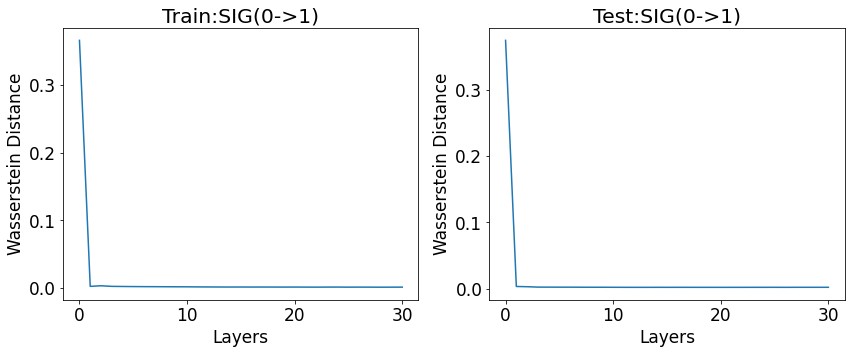

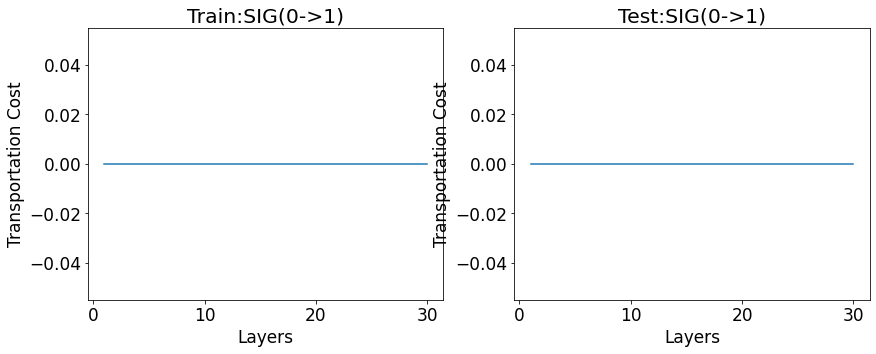

In [ ]:
eval_dict['SIG(0->1)'] = allplot(sig_real_train,sig_real_test,sig_tc_train,sig_tc_test,'SIG(0->1)',original_wd_train,original_wd_test)

### sig(10)

In [ ]:
sig_real_train= np.zeros((n_rep,n_layers))
sig_real_test= np.zeros((n_rep,n_layers))

sig_tc_train= np.zeros((n_rep,n_layers))
sig_tc_test= np.zeros((n_rep,n_layers))

device = torch.device('cuda')
# training 

# rearrange the data
class_list = [0,1]
n_samples_list = [len(np.nonzero(y_train==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)

X0 = X_train[y_train==0,:]
X0 = X_train[np.nonzero(y_train==0)[0]]
X0 = X0[:n_samples]
y0 = y_train[np.nonzero(y_train==0)[0]]
y0 = y0[:n_samples]
X1 = X_train[np.nonzero(y_train==1)[0]]
X1 = X1[:n_samples]
y1 = y_train[np.nonzero(y_train==1)[0]]
y1 = y1[:n_samples]

X = np.concatenate((X0,X1))
y = np.concatenate((y0,y1))


# Evaluation
# rearrange the data
n_samples_list_test = [len(np.nonzero(y_test==l)[0]) for l in class_list]
n_samples_test = np.min(n_samples_list_test)
X0 = X_test[np.nonzero(y_test==0)[0]]
X0 = X0[:n_samples_test]
y0 = y_test[np.nonzero(y_test==0)[0]]
y0 = y0[:n_samples_test]
X1 = X_test[np.nonzero(y_test==1)[0]]
X1 = X1[:n_samples_test]
y1 = y_test[np.nonzero(y_test==1)[0]]
y1 = y1[:n_samples_test]

X_test = np.concatenate((X0,X1))
y_test = np.concatenate((y0,y1))

In [ ]:

for t in range(n_rep):

    cd_dict = dict()

    # training of SIG

    n_classes = len(class_list)
    device = torch.device('cuda')

    KDE = False
    nsample_A = int(len(X)/n_classes)
    nsample_spline = int(len(X)/n_classes)
    #nsample = nsample_wT + nsample_spline 
    batchsize = int(len(X)/n_classes)

    K=2
    cd_sig = SIG(2,y)

    z = dict()

    z = dict()
    for yy in class_list:
        z_temp = torch.Tensor(X[np.nonzero(y == yy)[0]])
        z[yy]  = z_temp
    # ,X, y, z_dict,k, nsample_A, nsample_spline, layer_type='regular', batchsize=None, sample_test= None, put_data_on_disk=False


    for i in range(n_layers):
        z = cd_sig.add_newlayer(torch.Tensor(X), y, z, K, nsample_A, nsample_spline,'regular', batchsize=batchsize,put_data_on_disk = False)

        #train evaluation
        Z_temp = 0
        X_temp = cd_sig.inverse(torch.Tensor(X),y)
        X_temp_inv = cd_sig(torch.Tensor(X),1-y)
        X_temp01 = torch.cat((X_temp_inv[y==0],X_temp[y==1]))

        #plt.figure(figsize=(5,5))
        #plt.scatter(*Z_temp.T, c=y, s=2, cmap='rainbow')
        #plt.show()

        tc_temp = 0
        wd_real_temp = wd_average(X, X_temp01, y, n_samples)
        #wd_real_list.append(wd_real_temp)
        sig_real_train[t,i] = wd_real_temp
        sig_tc_train[t,i] = tc_temp

        Z_temp = 0
        X_temp = cd_sig.inverse(torch.Tensor(X_test),y_test)
        X_temp_inv = cd_sig(torch.Tensor(X_test),1-y_test)
        X_temp01 = torch.cat((X_temp_inv[y_test==0],X_temp[y_test==1]))
        #wd_latent_temp = wd_sinkhorn(Z_temp, y, n_samples).detach().numpy()
        #swd_latent_test[t,i-1] = wd_latent_temp
        #wd_latent_list.append(wd_latent_temp)
        wd_real_temp = wd_average(X_test, X_temp01, y_test, n_samples_test)
        tc_temp =0
        #wd_real_list.append(wd_real_temp)
        sig_real_test[t,i] = wd_real_temp
        sig_tc_test[t,i] = tc_temp

    # plt.figure(figsize=(5,5))
    # plt.scatter(*X.T, c=y, s=2, cmap='rainbow')
    # plt.tick_params(labelsize=14)
    # plt.xlim(-1.5,2.5)
    # plt.ylim(-1,1.5)
    # plt.title('test')
    # #plt.title('Original Test')
    # #plt.savefig('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/figures/two_toy/moon_ori.png', bbox_inches='tight')
    # plt.show()


    

    


Fit A: Time: 0.0298056640625 Wasserstein Distance: [1.2952890396118164, 0.33042269945144653]
Fit spline Time: 0.004456352233886718
Nlayer: 1 Time: 0.040780704498291014 regular

Fit A: Time: 0.030876031875610353 Wasserstein Distance: [1.2952728271484375, 0.3304862380027771]
Fit spline Time: 0.004419871807098389
Nlayer: 1 Time: 0.045115360260009764 regular

Fit A: Time: 0.06948310089111329 Wasserstein Distance: [0.06629638373851776, 0.04211366921663284]
Fit spline Time: 0.004764416217803955
Nlayer: 2 Time: 0.08012461090087891 regular

Fit A: Time: 0.07032262420654296 Wasserstein Distance: [0.055107537657022476, 0.03488428518176079]
Fit spline Time: 0.003972959995269775
Nlayer: 2 Time: 0.07961897277832031 regular

Fit A: Time: 0.04894831848144531 Wasserstein Distance: [0.020676186308264732, 0.013463445007801056]
Fit spline Time: 0.005783071994781494
Nlayer: 3 Time: 0.06015318298339844 regular

Fit A: Time: 0.03837443161010742 Wasserstein Distance: [0.022147251293063164, 0.0220692381262779

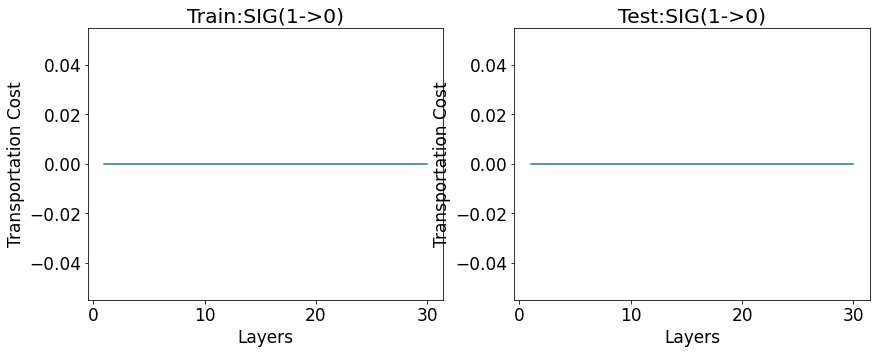

In [ ]:
eval_dict['SIG(1->0)'] = allplot(sig_real_train,sig_real_test,sig_tc_train,sig_tc_test,'SIG(1->0)',original_wd_train,original_wd_test)

### other

Train (2000, 2), Test: (1000, 2))


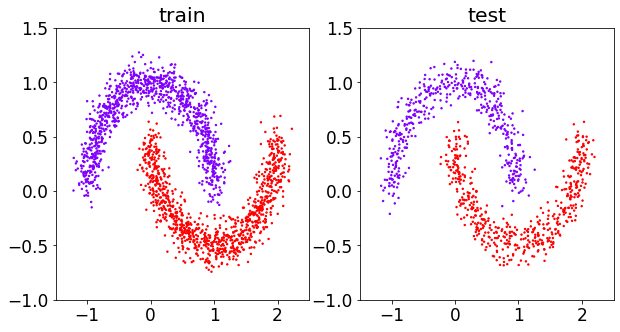

In [ ]:
# Make data
rng = np.random.RandomState(0)
X, y = make_moons(n_samples=3000, noise=0.1, random_state=rng)
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2000, random_state=rng)
# torch.save(X_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_train.pt')
# torch.save(y_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_train.pt')
# torch.save(X_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_test.pt')
# torch.save(y_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_test.pt')

# Load data
X_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_train.pt')
y_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_train.pt')
X_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_test.pt')
y_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_test.pt')

print(f'Train {X_train.shape}, Test: {X_test.shape})')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*X_train.T, c=y_train, s=2, cmap='rainbow')
ax1.set_title('train')
ax2.scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
ax2.set_title('test')
ax1.set_xlim(-1.5,2.5)
ax1.set_ylim(-1,1.5)
ax2.set_xlim(-1.5,2.5)
ax2.set_ylim(-1,1.5)
plt.show()

In [ ]:
rand_real_train= np.zeros((n_rep,n_layers))
rand_real_test= np.zeros((n_rep,n_layers))

rand_tc_train= np.zeros((n_rep,n_layers))
rand_tc_test= np.zeros((n_rep,n_layers))

for t in range(n_rep):

    # training 

    # rearrange the data
    class_list = [0,1]
    n_samples_list = [len(np.nonzero(y_train==l)[0]) for l in class_list]
    n_samples = np.min(n_samples_list)

    X0 = X_train[y_train==0,:]
    X0 = X_train[np.nonzero(y_train==0)[0]]
    X0 = X0[:n_samples]
    y0 = y_train[np.nonzero(y_train==0)[0]]
    y0 = y0[:n_samples]
    X1 = X_train[np.nonzero(y_train==1)[0]]
    X1 = X1[:n_samples]
    y1 = y_train[np.nonzero(y_train==1)[0]]
    y1 = y1[:n_samples]

    X = np.concatenate((X0,X1))
    y = np.concatenate((y0,y1))

    cd_dict = dict()

    # training of mSWD-NB

    cd = MSWDBaryClassifierDestructor()

    Z = torch.clone(torch.Tensor(X))

    for i in range(n_layers):
        cd, Z = add_one_layer(cd, Z, y, 'nb', ndim=2, rand=True)
    X_flip = cd.inverse(Z, 1 - y)

    cd_dict['Rand-NB'] = cd
    del(cd)

    # fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
    # ax1.scatter(*Z_swd_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
    # ax1.set_title('mSWD-NB')
    # ax2.scatter(*X_swd_nb_flip.T.detach().numpy(), c=1-y, s=2, cmap='rainbow')
    # ax2.set_title('mSWD-NB-1')
    # ax1.set_xlim(-1.5,2.5)
    # ax1.set_ylim(-1,1.5)
    # ax2.set_xlim(-1.5,2.5)
    # ax2.set_ylim(-1,1.5)
    # plt.show()
    cd = cd_dict['Rand-NB']
    for i in range(1,n_layers+1):
        Z_temp = cd.partial_forward(X,y,i,toy=True)
        X_temp = cd.partial_inverse(Z_temp,1-y,i,toy=True)
        #wd_latent_temp = wd_sinkhorn(Z_temp, y, n_samples).detach().numpy()
        #swd_latent_train[t,i-1] = wd_latent_temp
        #wd_latent_list.append(wd_latent_temp)
        tc_temp = transport_cost(X, Z_temp,y)
        wd_real_temp = wd_average(X, X_temp, y, n_samples)
        #wd_real_list.append(wd_real_temp)
        rand_real_train[t,i-1] = wd_real_temp
        rand_tc_train[t,i-1] = tc_temp

    # Evaluation
    # rearrange the data
    n_samples_list = [len(np.nonzero(y_test==l)[0]) for l in class_list]
    n_samples = np.min(n_samples_list)
    X0 = X_test[np.nonzero(y_test==0)[0]]
    X0 = X0[:n_samples]
    y0 = y_test[np.nonzero(y_test==0)[0]]
    y0 = y0[:n_samples]
    X1 = X_test[np.nonzero(y_test==1)[0]]
    X1 = X1[:n_samples]
    y1 = y_test[np.nonzero(y_test==1)[0]]
    y1 = y1[:n_samples]

    X = np.concatenate((X0,X1))
    y = np.concatenate((y0,y1))

    # plt.figure(figsize=(5,5))
    # plt.scatter(*X.T, c=y, s=2, cmap='rainbow')
    # plt.tick_params(labelsize=14)
    # plt.xlim(-1.5,2.5)
    # plt.ylim(-1,1.5)
    # plt.title('test')
    # #plt.title('Original Test')
    # #plt.savefig('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/figures/two_toy/moon_ori.png', bbox_inches='tight')
    # plt.show()


    cd = cd_dict['Rand-NB']
    #wd_latent_list = []
    #wd_real_list = []

    for i in range(1,n_layers+1):
        Z_temp = cd.partial_forward(X,y,i,toy=True)
        X_temp = cd.partial_inverse(Z_temp,1-y,i,toy=True)
        #wd_latent_temp = wd_sinkhorn(Z_temp, y, n_samples).detach().numpy()
        #swd_latent_test[t,i-1] = wd_latent_temp
        #wd_latent_list.append(wd_latent_temp)
        wd_real_temp = wd_average(X, X_temp, y, n_samples)
        tc_temp = transport_cost(X, Z_temp,y)
        #wd_real_list.append(wd_real_temp)
        rand_real_test[t,i-1] = wd_real_temp
        rand_tc_test[t,i-1] = tc_temp


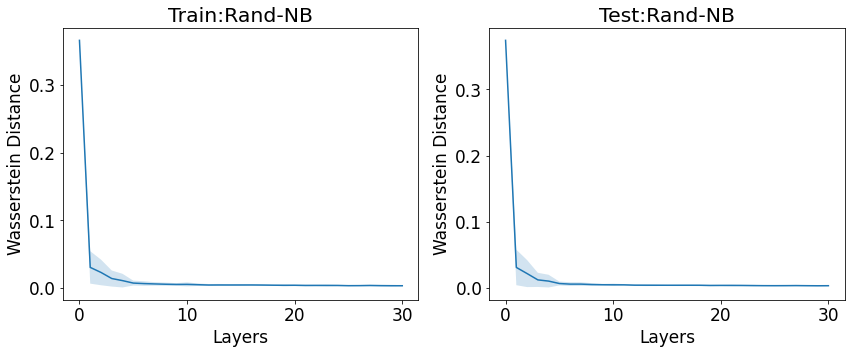

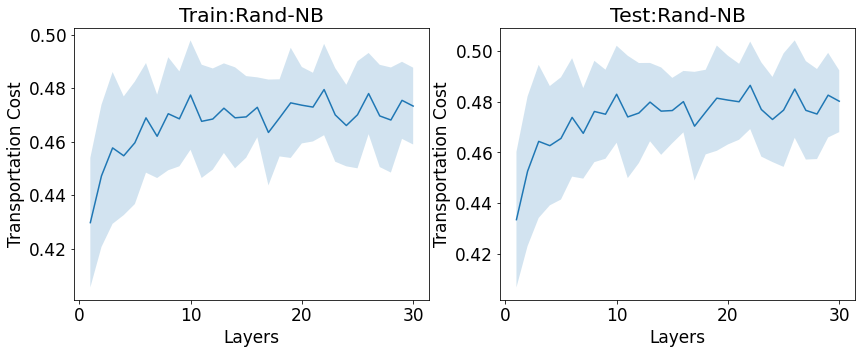

In [ ]:
eval_dict['Rand-NB'] = allplot(rand_real_train,rand_real_test,rand_tc_train,rand_tc_test,'Rand-NB',original_wd_train,original_wd_test)

In [ ]:
swd_real_train= np.zeros((n_rep,n_layers))
swd_real_test= np.zeros((n_rep,n_layers))

swd_tc_train= np.zeros((n_rep,n_layers))
swd_tc_test= np.zeros((n_rep,n_layers))

for t in range(n_rep):

    # training 

    # rearrange the data
    class_list = [0,1]
    n_samples_list = [len(np.nonzero(y_train==l)[0]) for l in class_list]
    n_samples = np.min(n_samples_list)

    X0 = X_train[y_train==0,:]
    X0 = X_train[np.nonzero(y_train==0)[0]]
    X0 = X0[:n_samples]
    y0 = y_train[np.nonzero(y_train==0)[0]]
    y0 = y0[:n_samples]
    X1 = X_train[np.nonzero(y_train==1)[0]]
    X1 = X1[:n_samples]
    y1 = y_train[np.nonzero(y_train==1)[0]]
    y1 = y1[:n_samples]

    X = np.concatenate((X0,X1))
    y = np.concatenate((y0,y1))

    cd_dict = dict()

    # training of mSWD-NB

    cd_swd_nb = MSWDBaryClassifierDestructor()

    Z_swd_nb = torch.clone(torch.Tensor(X))

    for i in range(n_layers):
        cd_swd_nb, Z_swd_nb = add_one_layer(cd_swd_nb, Z_swd_nb, y, 'nb', ndim=2)
    X_swd_nb_flip = cd_swd_nb.inverse(Z_swd_nb, 1 - y)

    cd_dict['mSWD-NB'] = cd_swd_nb
    del(cd_swd_nb)

    # fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
    # ax1.scatter(*Z_swd_nb.T.detach().numpy(), c=y, s=2, cmap='rainbow')
    # ax1.set_title('mSWD-NB')
    # ax2.scatter(*X_swd_nb_flip.T.detach().numpy(), c=1-y, s=2, cmap='rainbow')
    # ax2.set_title('mSWD-NB-1')
    # ax1.set_xlim(-1.5,2.5)
    # ax1.set_ylim(-1,1.5)
    # ax2.set_xlim(-1.5,2.5)
    # ax2.set_ylim(-1,1.5)
    # plt.show()
    cd = cd_dict['mSWD-NB']
    for i in range(1,n_layers+1):
        Z_temp = cd.partial_forward(X,y,i,toy=True)
        X_temp = cd.partial_inverse(Z_temp,1-y,i,toy=True)
        #wd_latent_temp = wd_sinkhorn(Z_temp, y, n_samples).detach().numpy()
        #swd_latent_train[t,i-1] = wd_latent_temp
        #wd_latent_list.append(wd_latent_temp)
        wd_real_temp = wd_average(X, X_temp, y, n_samples)
        tc_temp = transport_cost(X, Z_temp,y)
        #wd_real_list.append(wd_real_temp)
        swd_real_train[t,i-1] = wd_real_temp
        swd_tc_train[t,i-1] = tc_temp


    # Evaluation
    # rearrange the data
    n_samples_list = [len(np.nonzero(y_test==l)[0]) for l in class_list]
    n_samples = np.min(n_samples_list)
    X0 = X_test[np.nonzero(y_test==0)[0]]
    X0 = X0[:n_samples]
    y0 = y_test[np.nonzero(y_test==0)[0]]
    y0 = y0[:n_samples]
    X1 = X_test[np.nonzero(y_test==1)[0]]
    X1 = X1[:n_samples]
    y1 = y_test[np.nonzero(y_test==1)[0]]
    y1 = y1[:n_samples]

    X = np.concatenate((X0,X1))
    y = np.concatenate((y0,y1))

    # plt.figure(figsize=(5,5))
    # plt.scatter(*X.T, c=y, s=2, cmap='rainbow')
    # plt.tick_params(labelsize=14)
    # plt.xlim(-1.5,2.5)
    # plt.ylim(-1,1.5)
    # plt.title('test')
    # #plt.title('Original Test')
    # #plt.savefig('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/figures/two_toy/moon_ori.png', bbox_inches='tight')
    # plt.show()


    cd = cd_dict['mSWD-NB']
    #wd_latent_list = []
    #wd_real_list = []

    for i in range(1,n_layers+1):
        Z_temp = cd.partial_forward(X,y,i,toy=True)
        X_temp = cd.partial_inverse(Z_temp,1-y,i,toy=True)
        #wd_latent_temp = wd_sinkhorn(Z_temp, y, n_samples).detach().numpy()
        #swd_latent_test[t,i-1] = wd_latent_temp
        #wd_latent_list.append(wd_latent_temp)
        wd_real_temp = wd_average(X, X_temp, y, n_samples)
        tc_temp = transport_cost(X, Z_temp,y)
        #wd_real_list.append(wd_real_temp)
        swd_real_test[t,i-1] = wd_real_temp
        swd_tc_test[t,i-1] = tc_temp

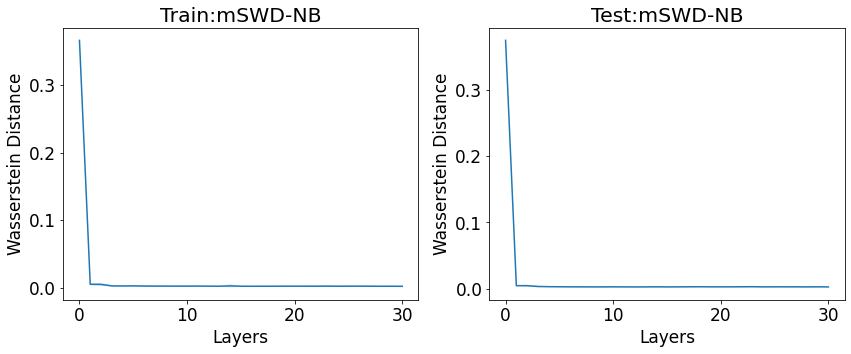

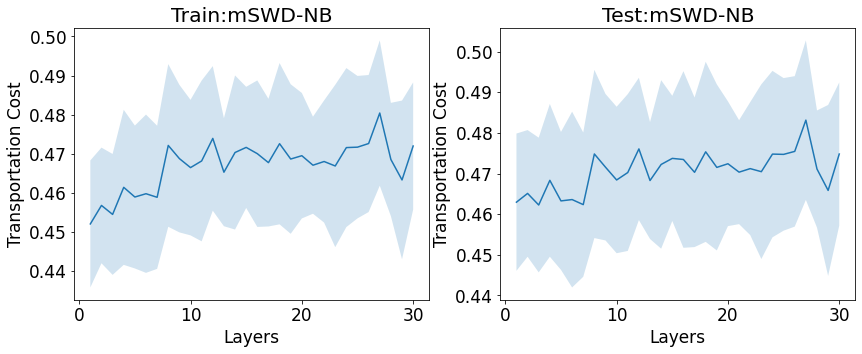

In [ ]:
eval_dict['INB'] = allplot(swd_real_train,swd_real_test,swd_tc_train,swd_tc_test,'mSWD-NB',original_wd_train,original_wd_test)

In [ ]:
dd_real_train= np.zeros((n_rep,n_layers))
dd_real_test= np.zeros((n_rep,n_layers))

dd_tc_train= np.zeros((n_rep,n_layers))
dd_tc_test= np.zeros((n_rep,n_layers))

for t in range(n_rep):

    # training 

    # rearrange the data
    class_list = [0,1]
    n_samples_list = [len(np.nonzero(y_train==l)[0]) for l in class_list]
    n_samples = np.min(n_samples_list)

    X0 = X_train[y_train==0,:]
    X0 = X_train[np.nonzero(y_train==0)[0]]
    X0 = X0[:n_samples]
    y0 = y_train[np.nonzero(y_train==0)[0]]
    y0 = y0[:n_samples]
    X1 = X_train[np.nonzero(y_train==1)[0]]
    X1 = X1[:n_samples]
    y1 = y_train[np.nonzero(y_train==1)[0]]
    y1 = y1[:n_samples]

    X = np.concatenate((X0,X1))
    y = np.concatenate((y0,y1))

    cd_dict = dict()

    copula_destructor = CompositeDestructor([
    IndependentInverseCdf(),
    LinearProjector(linear_estimator=RandomOrthogonalEstimator()),
    IndependentDestructor(),
    IndependentDestructor(IndependentDensity(HistogramUnivariateDensity(
        bins=40, bounds=[0, 1], alpha=1))),
    ])

    cd_dd = DeepDestructor(
        init_destructor=DensityConditionalDestructor(
            density_destructor=IndependentDestructor()),
        canonical_destructor=DensityConditionalDestructor(
            density_destructor=copula_destructor),
        n_canonical_destructors=n_layers -1  ,
        random_state=np.random.RandomState(0), # Random state set for all estimators
    )


    with warnings.catch_warnings():
        warnings.simplefilter('ignore') # Ignore boundary warnings
        Z_dd = cd_dd.fit_transform(X, y)
    X_dd_flip = cd_dd.inverse_transform(Z_dd, 1 - y)

    cd_dict['DD'] = cd_dd
    del(cd_dd)


    cd = cd_dict['DD']
    for i in range(1,n_layers+1 ):
        Z_temp = cd.transform(X,y,partial_idx=list(range(i)))
        X_temp = cd.inverse_transform(Z_temp,1-y,partial_idx=list(range(i)))
        #wd_latent_temp = wd_sinkhorn(Z_temp, y, n_samples).detach().numpy()
        #wd_latent_list.append(wd_latent_temp)
        wd_real_temp = wd_average(X, X_temp, y, n_samples)
        #wd_real_list.append(wd_real_temp)
        tc_temp = transport_cost(X, Z_temp,y)

        #dd_latent_train[t,i-1] = wd_latent_temp
        #wd_latent_list.append(wd_latent_temp)
        #wd_real_list.append(wd_real_temp)
        dd_tc_train[t,i-1] = tc_temp
        dd_real_train[t,i-1] = wd_real_temp

    
    # Evaluation
    # rearrange the data
    n_samples_list = [len(np.nonzero(y_test==l)[0]) for l in class_list]
    n_samples = np.min(n_samples_list)
    X0 = X_test[np.nonzero(y_test==0)[0]]
    X0 = X0[:n_samples]
    y0 = y_test[np.nonzero(y_test==0)[0]]
    y0 = y0[:n_samples]
    X1 = X_test[np.nonzero(y_test==1)[0]]
    X1 = X1[:n_samples]
    y1 = y_test[np.nonzero(y_test==1)[0]]
    y1 = y1[:n_samples]

    X = np.concatenate((X0,X1))
    y = np.concatenate((y0,y1))

    cd = cd_dict['DD']
    for i in range(1,n_layers+1 ):
        Z_temp = cd.transform(X,y,partial_idx=list(range(i)))
        X_temp = cd.inverse_transform(Z_temp,1-y,partial_idx=list(range(i)))
        #wd_latent_temp = wd_sinkhorn(Z_temp, y, n_samples).detach().numpy()
        #wd_latent_list.append(wd_latent_temp)
        wd_real_temp = wd_average(X, X_temp, y, n_samples)
        #wd_real_list.append(wd_real_temp)
        tc_temp = transport_cost(X, Z_temp,y)
        #dd_latent_test[t,i-1] = wd_latent_temp
        #wd_latent_list.append(wd_latent_temp)
        #wd_real_list.append(wd_real_temp)
        dd_real_test[t,i-1] = wd_real_temp
        dd_tc_test[t,i-1] = tc_temp

In [ ]:
eval_dict['DD'] = allplot(dd_real_train,dd_real_test,dd_tc_train,dd_tc_test,'DD',original_wd_train,original_wd_test)

In [ ]:
# tree_real_train= np.zeros((n_rep,n_layers))
# tree_real_test= np.zeros((n_rep,n_layers))
# tree_tc_train= np.zeros((n_rep,n_layers))
# tree_tc_test= np.zeros((n_rep,n_layers))

# for t in range(n_rep):

#     # training 

#     # rearrange the data
#     class_list = [0,1]
#     n_samples_list = [len(np.nonzero(y_train==l)[0]) for l in class_list]
#     n_samples = np.min(n_samples_list)

#     X0 = X_train[y_train==0,:]
#     X0 = X_train[np.nonzero(y_train==0)[0]]
#     X0 = X0[:n_samples]
#     y0 = y_train[np.nonzero(y_train==0)[0]]
#     y0 = y0[:n_samples]
#     X1 = X_train[np.nonzero(y_train==1)[0]]
#     X1 = X1[:n_samples]
#     y1 = y_train[np.nonzero(y_train==1)[0]]
#     y1 = y1[:n_samples]

#     X = np.concatenate((X0,X1))
#     y = np.concatenate((y0,y1))

#     cd_dict = dict()

#     cd_tree = create_deep_tree_cd(n_layers)

#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore') # Ignore boundary warnings
#         Z_tree = cd_tree.fit_transform(X, y)
#     X_tree_flip = cd_tree.inverse_transform(Z_tree, 1- y)
#     cd_dict['tree'] = cd_tree
#     del(cd_tree)


#     cd = cd_dict['tree']
#     for i in range(1,n_layers+1 ):
#         Z_temp = cd.transform(X,y,partial_idx=list(range(i)))
#         X_temp = cd.inverse_transform(Z_temp,1-y,partial_idx=list(range(i)))
#         #wd_latent_temp = wd_sinkhorn(Z_temp, y, n_samples).detach().numpy()
#         #wd_latent_list.append(wd_latent_temp)
#         wd_real_temp = wd_average(X, X_temp, y, n_samples)
#         tc_temp = transport_cost(X, Z_temp,y)
#         #wd_real_list.append(wd_real_temp)

#         #tree_latent_train[t,i-1] = wd_latent_temp
#         #wd_latent_list.append(wd_latent_temp)
#         #wd_real_list.append(wd_real_temp)
#         tree_real_train[t,i-1] = wd_real_temp
#         tree_tc_train[t,i-1] = tc_temp


    
#     # Evaluation
#     # rearrange the data
#     n_samples_list = [len(np.nonzero(y_test==l)[0]) for l in class_list]
#     n_samples = np.min(n_samples_list)
#     X0 = X_test[np.nonzero(y_test==0)[0]]
#     X0 = X0[:n_samples]
#     y0 = y_test[np.nonzero(y_test==0)[0]]
#     y0 = y0[:n_samples]
#     X1 = X_test[np.nonzero(y_test==1)[0]]
#     X1 = X1[:n_samples]
#     y1 = y_test[np.nonzero(y_test==1)[0]]
#     y1 = y1[:n_samples]

#     X = np.concatenate((X0,X1))
#     y = np.concatenate((y0,y1))

#     cd = cd_dict['tree']
#     for i in range(1,n_layers+1 ):
#         Z_temp = cd.transform(X,y,partial_idx=list(range(i)))
#         X_temp = cd.inverse_transform(Z_temp,1-y,partial_idx=list(range(i)))
#         #wd_latent_temp = wd_sinkhorn(Z_temp, y, n_samples).detach().numpy()
#         #wd_latent_list.append(wd_latent_temp)
#         wd_real_temp = wd_average(X, X_temp, y, n_samples)
#         tc_temp = transport_cost(X, Z_temp,y)
#         #wd_real_list.append(wd_real_temp)

#         #tree_latent_test[t,i-1] = wd_latent_temp
#         #wd_latent_list.append(wd_latent_temp)
#         #wd_real_list.append(wd_real_temp)
#         tree_real_test[t,i-1] = wd_real_temp
#         tree_tc_test[t,i-1] = tc_temp

In [ ]:
# eval_dict['Tree'] = allplot(tree_real_train,tree_real_test,tree_tc_train,tree_tc_test,'Tree',original_wd_train,original_wd_test)

In [ ]:
# eval_dict = np.load('/content/drive/MyDrive/2020 Summer Research/Iterative Barycenter Flow/ICML-Extra Experiment/convergence.pt.npy',allow_pickle=True)
# eval_dict = eval_dict.item()
# n_layers=30

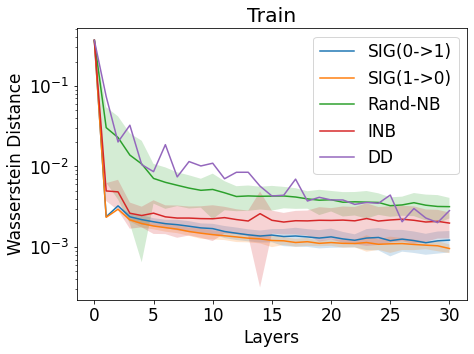

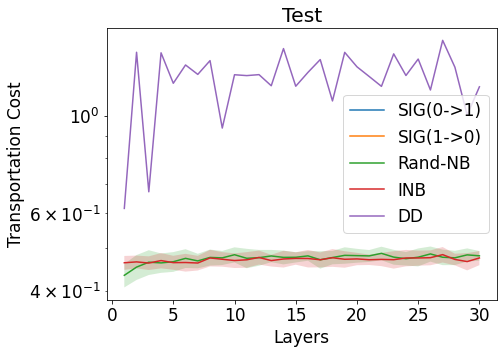

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(7,5))
idx = list(range(0,n_layers+1))
for labels,dic in eval_dict.items():
    ax.semilogy(idx,dic['wd_mean_train'], label = labels)
    ax.fill_between(idx,dic['wd_mean_train'] - dic['wd_std_train'], dic['wd_mean_train'] + dic['wd_std_train'] , alpha=0.2)
plt.legend()
plt.title('Train')
plt.xlabel('Layers')
plt.ylabel('Wasserstein Distance')
plt.savefig('/content/drive/MyDrive/2020 Summer Research/Iterative Barycenter Flow/ICML-Extra Experiment/wd_train.png',bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1,figsize=(7,5))
for labels,dic in eval_dict.items():
    ax.semilogy(idx,dic['wd_mean_test'], label = labels)
    ax.fill_between(idx,dic['wd_mean_test'] - dic['wd_std_test'], dic['wd_mean_test'] + dic['wd_std_test'] , alpha=0.2)
plt.legend()
plt.title('Test')
plt.xlabel('Layers')
plt.ylabel('Wasserstein Distance')
plt.savefig('/content/drive/MyDrive/2020 Summer Research/Iterative Barycenter Flow/ICML-Extra Experiment/wd_test.png',bbox_inches='tight')
plt.show()

idx = list(range(1,n_layers+1))
fig, ax = plt.subplots(1, 1,figsize=(7,5))
for labels,dic in eval_dict.items():
    ax.semilogy(idx,dic['tc_mean_train'], label = labels)
    ax.fill_between(idx,dic['tc_mean_train'] - dic['tc_std_train'], dic['tc_mean_train'] + dic['tc_std_train'] , alpha=0.2)

plt.legend()
plt.title('Train')
plt.xlabel('Layers')
plt.ylabel('Transportation Cost')
plt.savefig('/content/drive/MyDrive/2020 Summer Research/Iterative Barycenter Flow/ICML-Extra Experiment/tc_train.png',bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1,figsize=(7,5))
for labels,dic in eval_dict.items():
    ax.semilogy(idx,dic['tc_mean_test'], label = labels)
    ax.fill_between(idx,dic['tc_mean_test'] - dic['tc_std_test'], dic['tc_mean_test'] + dic['tc_std_test'] , alpha=0.2)
plt.legend()
plt.title('Test')
plt.xlabel('Layers')
plt.ylabel('Transportation Cost')
plt.savefig('/content/drive/MyDrive/2020 Summer Research/Iterative Barycenter Flow/ICML-Extra Experiment/tc_test.png',bbox_inches='tight')
plt.show()

#np.save('/content/drive/MyDrive/2020 Summer Research/Iterative Barycenter Flow/ICML-Extra Experiment/convergence.pt',eval_dict)

In [ ]:
# set the limit 
idx = list(range(0,n_layers+1))
plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(1, 1,figsize=(7,5))
for labels,dic in eval_dict.items():
    ax.semilogy(idx,dic['wd_mean_test'], label = labels)
    ax.fill_between(idx,dic['wd_mean_test'] - dic['wd_std_test'], dic['wd_mean_test'] + dic['wd_std_test'] , alpha=0.2)
plt.legend()
plt.title('Test')
plt.xlabel('Layers')
plt.ylabel('Wasserstein Distance')
plt.ylim(top=0.2,bottom=0.0015)
plt.savefig('/content/drive/MyDrive/2020 Summer Research/Iterative Barycenter Flow/ICML-Extra Experiment/wd_test_0.2.png',bbox_inches='tight')